In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import glob
import os
import numpy as np
from PIL import Image
import torchvision.models as models
import copy
from torchvision.utils import save_image
import PIL
from torch.autograd import Variable
from models import VAE, loss_function
import training_helper as th
import skimage.io
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE

In [2]:
#preperations
trainset = th.imgData(root='hw3_data/p1_npy')
trainset_loader = DataLoader(trainset, batch_size=4096, shuffle=True, num_workers=0)

device = th.getCudaDevice(cudaNum = 0, torchSeed = 123)

model = VAE(100, device)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

th.loadModel('p1_latest.pth', model, optimizer)

train_MSE = np.load('hw3_data/p1_plot_npy/train_MSE.npy')
train_KLD = np.load('hw3_data/p1_plot_npy/train_KLD.npy')

Device used: cuda:0
model loaded from p1_latest.pth


In [3]:
# question 1
print(model)

VAE(
  (conv_stage): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01, inplace=True)
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (fcMean): Linear(in_features=4096, out_features=100, bias=True)
  (fcStd): Linear(i

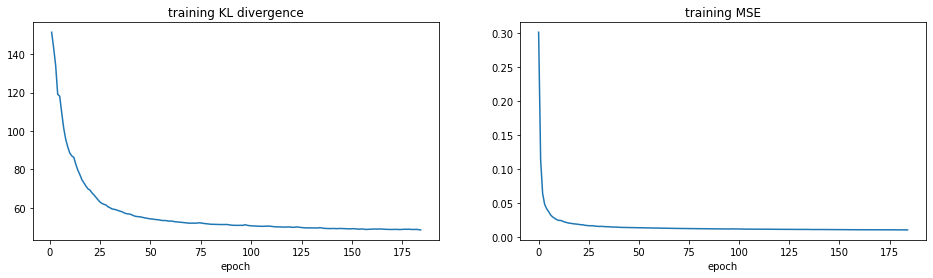

In [4]:
# question 2
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
ep = range(1,len(train_KLD))
plt.plot(ep,train_KLD[1:])
plt.title("training KL divergence")
plt.xlabel("epoch")

plt.subplot(1,2,2)
plt.plot(train_MSE)
plt.title("training MSE")
plt.xlabel("epoch")

plt.savefig('hw3_data/p1_report/question2.jpg')
plt.show()

mse = 0.0084 0.0104 0.0057 0.012 0.015 0.0127 0.0089 0.0153 0.0112 0.0122 


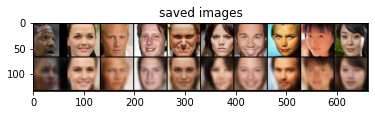

In [4]:
# question 3
model.eval()
randomImg = iter(trainset_loader).next()[:10].to(device)
recon, mu, logvar = model(randomImg)
pred = recon.data
savingTensor = torch.cat((randomImg,pred),0)
torchvision.utils.save_image(savingTensor, 'hw3_data/p1_report/question3.jpg', nrow=10)

testMSE = [float(F.mse_loss(Variable(pred[i]), Variable(randomImg[i])).data) for i in range(len(pred))]

#show saved image
showStr = ''
for mse in testMSE:
    showStr += str(round(mse, 4))+' '
print('mse =',showStr)
savedImg = skimage.io.imread('hw3_data/p1_report/question3.jpg')
fig, ax = plt.subplots()
ax.imshow(savedImg)
ax.set_title('saved images')
plt.show()

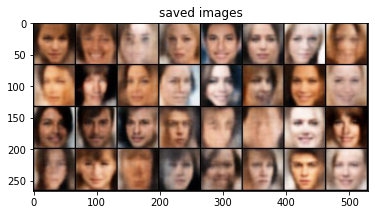

In [6]:
# question 4
with torch.no_grad():
    rand_variable = Variable(torch.randn(32,100)).to(device)
    #torch.save(rand_variable, 'p1_fixed_noise.pt')
    fixed_noise = torch.load('p1_fixed_noise.pt')
    results = model.decode(fixed_noise.to(device)).cpu()
torchvision.utils.save_image(results, 'hw3_data/p1_report/question4.jpg', nrow=8)

#show saved image
savedImg = skimage.io.imread('hw3_data/p1_report/question4.jpg')
fig, ax = plt.subplots()
ax.imshow(savedImg)
ax.set_title('saved images')
plt.show()

finish latent vector computation


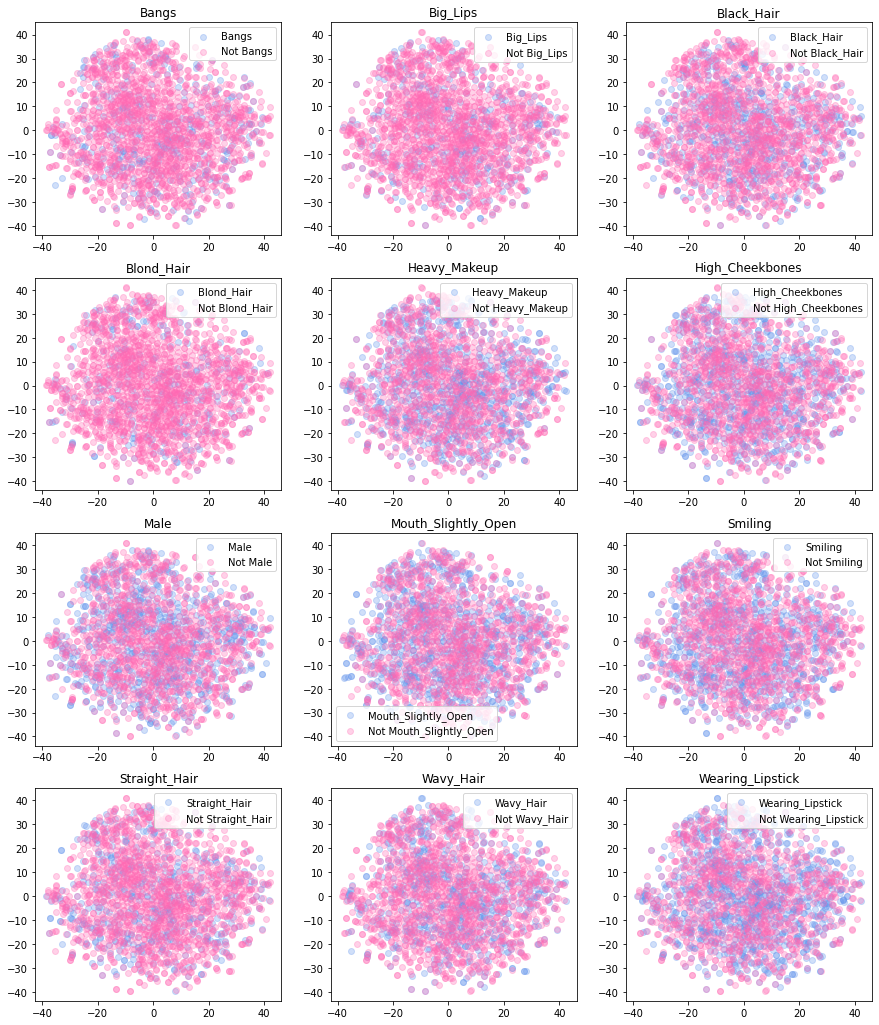

In [5]:
# question 5
data = iter(trainset_loader).next().to(device)
mu, logvar = model.encode(data)
with torch.no_grad():
    latentVectorList = mu.cpu().numpy()[:2000]

latentVectorList = TSNE(n_components = 2,perplexity = 30.0,random_state = 38).fit_transform(latentVectorList)
print('finish latent vector computation')

trainCsv = pd.read_csv("hw3_data/face/train.csv")
fig, ax = plt.subplots(4,3,figsize=(15,18))

def plotAxisWithLabels(labelString, ax):
    for i in [1,0]:
        label = np.array(trainCsv[labelString])
        color, gender = ("cornflowerblue", labelString) if i else ("hotpink", "Not "+labelString)
        x = [latentVector[0] for j, latentVector in enumerate(latentVectorList) if i == label[j]]
        y = [latentVector[1] for j, latentVector in enumerate(latentVectorList) if i == label[j]]
        ax.scatter(x, y, c = color, label = gender, alpha = 0.3)

labelList = ["Bangs", "Big_Lips", "Black_Hair", "Blond_Hair", "Heavy_Makeup", "High_Cheekbones",
            "Male", "Mouth_Slightly_Open", "Smiling", "Straight_Hair", "Wavy_Hair", "Wearing_Lipstick"]

for ind, label in enumerate(labelList):
    i, j = int(ind/3), ind % 3
    plotAxisWithLabels(label, ax[i][j])
    ax[i][j].legend()
    ax[i][j].set_title(label)
    
plt.savefig("hw3_data/p1_report/question5.jpg")
plt.show()